In [1]:
import utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import LTransform as LT

In [2]:
data_path = "./000128/sub-Jenkins/sub-Jenkins_ses-full_desc-train_behavior+ecephys.nwb"
D, trial_info, units = utils.read_mc_maze(data_path)
tools = utils.Analysis_tools(fs = 1000)

In [3]:
conds = trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()
reach_angles = []
for cond in conds:
# Determine reach angle for color
    mask = np.all(trial_info[['trial_type', 'trial_version']] == cond, axis=1)
    active_target = trial_info[mask].target_pos.iloc[0][trial_info[mask].active_target.iloc[0]]
    reach_angle = np.arctan2(*active_target[::-1])
    reach_angles.append(plt.cm.brg(reach_angle / (2*np.pi) + 0.5))

In [ ]:
which_unit = 2561
t = [1, 2]

t_pad = 0.5 # Seconds
dt = 1/1000

plt.subplot(2,1,1)
stem = tools.get_stem(units, which_unit, t, plot=True, dt=dt, t_pad=t_pad)
plt.subplot(2,1,2)
fr = tools.get_fr(which_unit, units, t, plot=True, dt=dt, t_pad=t_pad)

In [ ]:
condition_columns = ['trial_type', 'trial_version']
align_column = 'move_onset_time'
channel_column = 'hand_pos'
t_range = [-50, 450]

data_aligned = tools.align_continuous(trial_info, D, condition_columns, align_column, channel_column, t_range)

for i in range(data_aligned.shape[0]):
    plt.plot(data_aligned[i, :, 0], data_aligned[i, :, 1], color=reach_angles[i])


In [ ]:
%matplotlib inline  
condition_columns = ['trial_type', 'trial_version']
align_column = 'target_on_time'
#unit = [2561, 1011]
unit = units.index.values
t_range = [-10, 300]
data_aligned = tools.align_fr(trial_info, units, condition_columns, align_column, unit, t_range)

n_mean = np.mean(data_aligned, axis=0, keepdims=True)
n_range = np.max(np.vstack(data_aligned), axis=0, keepdims=True) - np.min(np.vstack(data_aligned), axis=0, keepdims=True)

rate_scaled = (data_aligned - n_mean)/(n_range+5)
transform = LT.Transform(num_latent=3)
transform.fit(rate_scaled, method='FA')
X_ld = transform.transform(rate_scaled, ensure_orthogonality=True)


fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
for c in range(108):
    ax.plot(X_ld[c, :, 0], X_ld[c,:, 1], X_ld[c,:, 2], lw=2, c=reach_angles[c])
    ax.scatter(X_ld[c,0, 0], X_ld[c,0, 1], X_ld[c,0, 2], color=reach_angles[c])
    ax.scatter(X_ld[c,-1, 0], X_ld[c,-1, 1], X_ld[c,-1, 2], marker = 'x' ,color=reach_angles[c])

In [ ]:
%matplotlib inline

condition_columns = ['trial_type', 'trial_version']
align_column = 'go_cue_time'
channel_column = 'hand_vel'
t_range = [-10, 200]

spd_align = tools.align_continuous(trial_info, D, condition_columns, align_column, channel_column, t_range)

plt.plot(np.sqrt(np.sum(spd_align**2, axis=2)).T, color='k')
plt.show()

#unit = [2561, 1011]
unit = units.index.values
data_aligned = tools.align_fr(trial_info, units, condition_columns, align_column, unit, t_range)

n_mean = np.mean(data_aligned, axis=0, keepdims=True)
n_range = np.max(np.vstack(data_aligned), axis=0, keepdims=True) - np.min(np.vstack(data_aligned), axis=0, keepdims=True)

rate_scaled = (data_aligned - n_mean)/(n_range+5)
transform = LT.Transform(num_latent=3)
transform.fit(rate_scaled, method='PCA')
X_ld = transform.transform(rate_scaled, ensure_orthogonality=True)


fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
for c in range(108):
    ax.plot(X_ld[c, :, 0], X_ld[c,:, 1], X_ld[c,:, 2], lw=2, c=reach_angles[c])
    ax.scatter(X_ld[c,0, 0], X_ld[c,0, 1], X_ld[c,0, 2], color=reach_angles[c])
    ax.scatter(X_ld[c,-1, 0], X_ld[c,-1, 1], X_ld[c,-1, 2], marker = 'x' ,color=reach_angles[c])

## Execution 

In [ ]:
%matplotlib inline
condition_columns = ['trial_type', 'trial_version']
align_column = 'move_onset_time'
channel_column = 'hand_vel'
t_range = [-50, 300]

spd_align = tools.align_continuous(trial_info, D, condition_columns, align_column, channel_column, t_range)

plt.plot(np.sqrt(np.sum(spd_align**2, axis=2)).T, color='k')
plt.show()

#unit = [2561, 1011]
unit = units.index.values
data_aligned = tools.align_fr(trial_info, units, condition_columns, align_column, unit, t_range)

n_mean = np.mean(data_aligned, axis=0, keepdims=True)
n_range = np.max(np.vstack(data_aligned), axis=0, keepdims=True) - np.min(np.vstack(data_aligned), axis=0, keepdims=True)


rate_scaled = (data_aligned - n_mean)/(n_range+5)
transform = LT.Transform(num_latent=3)
transform.fit(rate_scaled, method='PCA')
X_ld = transform.transform(rate_scaled, ensure_orthogonality=True)


fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
for c in range(108):
    ax.plot(X_ld[c, :, 0], X_ld[c,:, 1], X_ld[c,:, 2], lw=2, c=reach_angles[c])
    ax.scatter(X_ld[c,0, 0], X_ld[c,0, 1], X_ld[c,0, 2], color=reach_angles[c])
    ax.scatter(X_ld[c,-1, 0], X_ld[c,-1, 1], X_ld[c,-1, 2], marker = 'x' ,color=reach_angles[c])

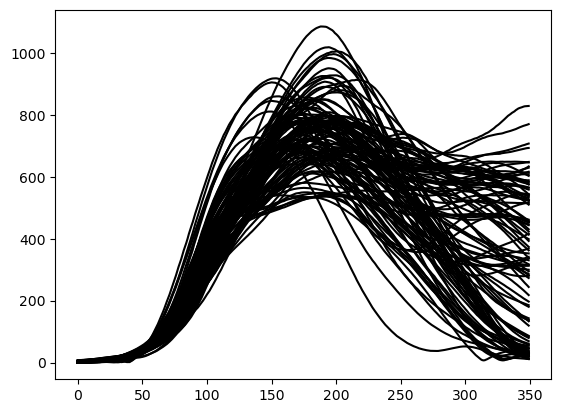

In [4]:
%matplotlib inline
condition_columns = ['trial_type', 'trial_version']
align_column = 'move_onset_time'
channel_column = 'hand_vel'
t_range = [-50, 300]

spd_align = tools.align_continuous(trial_info, D, condition_columns, align_column, channel_column, t_range)

plt.plot(np.sqrt(np.sum(spd_align**2, axis=2)).T, color='k')
plt.show()

unit = units.index.values
data_aligned = tools.align_fr(trial_info, units, condition_columns, align_column, unit, t_range)

Found tensor- Reshaping data to -1, num_unit
Found tensor- Reshaping data to -1, num_unit
R2 for linear fit: 0.326
Found tensor- Reshaping data to -1, num_unit
Found tensor- Reshaping data to -1, num_unit
Var explained by initial PCA 0.491
Var explained by 2 jPCs 0.188
Found tensor- Reshaping data to -1, num_unit


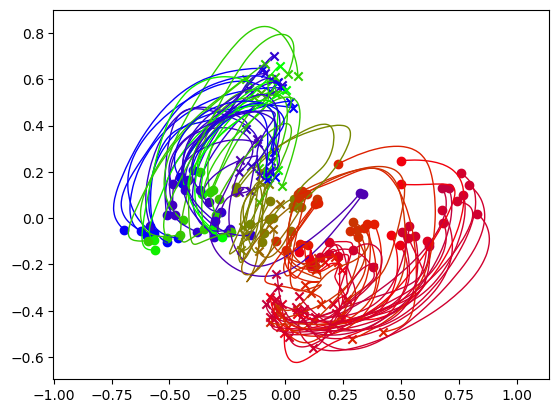

In [8]:
jpca = LT.jPCA(num_jpcs=6, force_skewness=True)
jpca.fit(data_aligned)
rate_jpca = jpca.transform(data_aligned)


for c in range(108):
    plt.plot(rate_jpca[c, :, 0], rate_jpca[c,:, 1], lw=1, c=reach_angles[c])
    plt.scatter(rate_jpca[c, 0, 0], rate_jpca[c,0, 1], color=reach_angles[c])
    plt.scatter(rate_jpca[c, -1, 0], rate_jpca[c,-1, 1], marker = 'x' ,color=reach_angles[c])
plt.axis('equal')
plt.show()

### Condition independent


In [ ]:
%matplotlib inline
condition_columns = ['trial_type', 'trial_version']
align_column = 'move_onset_time'
channel_column = 'hand_vel'
t_range = [-400, 300]

spd_align = tools.align_continuous(trial_info, D, condition_columns, align_column, channel_column, t_range)

plt.plot(np.sqrt(np.sum(spd_align**2, axis=2)).T, color='k')
plt.show()

unit = units.index.values
data_aligned = tools.align_fr(trial_info, units, condition_columns, align_column, unit, t_range)


In [ ]:
dpca = LT.dPCA(n_components=10)
dpca.fit(data_aligned)
Z = dpca.transform(data_aligned)

In [ ]:
ci_rate = Z['t'].transpose(1,2,0)
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
for c in range(108):
    ax.plot(ci_rate[c, :, 0], ci_rate[c,:, 1], ci_rate[c,:, 2], lw=2, c=reach_angles[c])
    

plt.show()
for c in range(108):
    plt.plot(ci_rate[c, :, 0], ci_rate[c,:, 1],lw=2, c=reach_angles[c])
plt.axis('equal')
plt.show()
